## Section 1 

# ***Living Coasts*** Information and Training <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the `DEA Sandbox` environment
* **Products used:** 
[ga_ls_landcover_class_cyear_2](https://explorer.sandbox.dea.ga.gov.au/ga_ls_landcover_class_cyear_2)


### Plotting changes in woody above ground biomass in a selected area

For selected areas, this notebook allows you to plot changes in woody above ground biomass for multiple years (2010 and annually from 2015-2021) using the global datasets generated by the European Space Agency (ESA) Climate Change Initiative (CCI) Biomass Project (https://climate.esa.int/en/projects/biomass/) and compare the spatial estimates over time with the changes in land cover, as mapped through Geoscience Australia's (GA) Digital Earth Australia (DEA) Land Cover Project.  These land cover maps have been generated for 34 years (1988 to 2020) from environmental descriptors retrieved or classified entirely from Landsat sensor data and according to the Food and Agriculture Organisation (FAO) Land Cover Classification System (Version 2).  If you can interrogate the land cover prior to 2010 (or up to any year after), you might be able to discern some of the reasons for observed AGB levels.  Comparing AGB over the more recent time-series (2010-2020) also informs on how changes in land cover extent and environmental descriptors relating to condition (e.g., canopy cover) have impacted on AGB over time. The spatial resolution of the mapping is 25 m (See DEA Land Cover: https://cmi.ga.gov.au/data-products/dea/607/dea-land-cover-landsat)

## Description 
The notebooks take you through the process of:

1. Observing the land cover changes that have occured over the selected area of interest.
2. Selecting an area of interest and extracting above ground biomass data for 8 years (2010 and annually from 2015 to 2021) and the associated standard deviation of the estimates.
3. Viewing the above ground biomass and change maps based on comparisons of 2010-2020, 2015-2016, 2016-2017, 2017-2018, 2018-2019, 2019-2020 and 2020-2021.

If you are new to DEA Land Cover, it is recommended you look at the introductory [DEA Land Cover notebook](../DEA_datasets/DEA_Land_Cover.ipynb) first. 

***

### Initial imports and setup

In [132]:
# Initial imports and setup
import sys
import os, re
import datacube
import datetime as dt
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.colors
import matplotlib as mpl
import cmocean # for intertidal products
import odc.geo.xr # RML
import pandas as pd
import rioxarray
import warnings
import xarray as xr
import display_tools
from display_tools import display_da
from pyproj import CRS

#from dea_tools.landcover import lc_colourmap, make_colorbar, plot_land_cover
from dea_tools.plotting import display_map, rgb, xr_animation # Added xr_animation RML

from datacube.testutils.io import rio_slurp_xarray
from datacube.utils.cog import write_cog
from datacube.utils.masking import mask_invalid_data
from datacube.utils.geometry import Geometry
from datetime import datetime, timedelta
from ipyleaflet import DrawControl, FullScreenControl, LayersControl, Map, Rectangle, WidgetControl, basemaps, GeoData # Added rectangle RML
from ipywidgets import Button, Dropdown, FloatText, GridspecLayout, Layout, HBox, VBox, Output, Tab, interact, widgets
from IPython.display import HTML, display
from IPython.core.display import Video
from pyproj import Proj, transform
from shapely.geometry import Polygon
from shapely.geometry.polygon import LinearRing
from time import time as time
warnings.filterwarnings("ignore")

# Setup paths and Datacube instance
#import sys
#sys.path.insert(1, "/home/Tools")

dc = datacube.Datacube()
time_range = None

sys.path.append("../Working")

from landcover import lc_colourmap, make_colorbar, plot_land_cover

# Ensure openpyxl is installed
!pip install openpyxl

# Initial imports and setup

import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
from matplotlib import colormaps
from matplotlib.patches import Patch

# Setup paths and Datacube instance
#current_dir = os.getcwd()
#tools_path = os.path.join(current_dir, "Tools")
#working_path = os.path.join(current_dir, "Working")

#sys.path.insert(1, tools_path)
#sys.path.insert(1, working_path)
dc = datacube.Datacube()

# Ensure openpyxl and tqdm are installed
!pip install openpyxl tqdm

time_range = None

# Function to import display_tools.py if exists
#def import_display_tools(path):
#    if os.path.exists(path) and "display_tools.py" in os.listdir(path):
#        try:
#            from display_tools import display_da
#            print(f"display_tools module imported successfully from {path}.")
#        except ImportError as e:
#            print(f"Error importing display_tools from {path}: {e}")
#    else:
#        print(f"display_tools.py not found in {path}.")

# Function to import landcover.py if exists
#def import_landcover(path):
#    if os.path.exists(path) and "landcover.py" in os.listdir(path):
#        try:
#            from landcover import lc_colourmap, make_colorbar, plot_land_cover
#            print(f"landcover module imported successfully from {path}.")
#        except ImportError as e:
#            print(f"Error importing landcover from {path}: {e}")
#    else:
#        print(f"landcover.py not found in {path}.")

# Import modules
#import_display_tools(tools_path)
#import_display_tools(working_path)
#import_landcover(working_path)

# List files in Tools and Working
#def list_files(path):
#    if os.path.exists(path):
#        print(f"Files in {path}:")
#        print(os.listdir(path))
#    else:
#        print(f"{path} does not exist.")

#list_files(tools_path)
#list_files(working_path)

#print("Section 1: Initial imports and setup - Completed")

# Manually invoke garbage collection without printing the result
import gc
import contextlib
with contextlib.redirect_stdout(None):
    gc.collect()

# Additional imports and setup
from odc.algo import xr_reproject
from dea_tools.plotting import rgb, display_map
from dea_tools.datahandling import wofs_fuser
from dea_tools.plotting import plot_wo
from matplotlib import colors as mcolours
from datacube.testutils.io import rio_slurp_xarray
from datacube.utils import masking
from datacube.utils.masking import mask_invalid_data
from datacube.utils.cog import write_cog
from odc.geo.geom import Geometry

# For DEA burn mapping
from datetime import datetime, timedelta

from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb, display_map
from dea_tools.bandindices import calculate_indices
from dea_tools.dask import create_local_dask_cluster

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

from wdc_datahandling import geopolygon_masking

2024-08-15 13:52:45,118 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/44343/status,
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/44343/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43839,Workers: 1
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/44343/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:45079,Total threads: 2
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/46313/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:36355,


###  Selecting your area of interest

In [133]:
from ipyleaflet import Map, DrawControl, Rectangle, WidgetControl, LayersControl, FullScreenControl, GeoJSON, basemaps
from ipywidgets import Button, VBox, Tab, FloatText, Output, Layout, HBox, HTML, Dropdown
from shapely.geometry import Polygon
import gc
import geopandas as gpd
from ipyfilechooser import FileChooser
import json

# Initialize global variables to store the selected polygon
selected_polygon = None
manual_polygon_layer = None
geojson_layer = None

# Define lat_range and lon_range to avoid NameError in Section 5
lat_range = None
lon_range = None

# Create the map
m = Map(center=[0, 0], zoom=2, basemap=basemaps.Esri.WorldImagery, scroll_wheel_zoom=True, layout=Layout(height='600px'))
m.add_control(LayersControl(position='topright'))
m.add_control(FullScreenControl())

# Output widgets to display coordinates
output_draw = Output(layout={'border': '1px solid black', 'padding': '5px'})
output_manual = Output(layout={'border': '1px solid black', 'padding': '5px'})
output_load = Output(layout={'border': '1px solid black', 'padding': '5px'})

### Draw Method ###
# Setup the draw control with both polygon and rectangle options
draw_control = DrawControl(
    rectangle={"shapeOptions": {"color": "#0000FF"}},
    polygon={"shapeOptions": {"color": "#00FF00"}},
    circlemarker={},
    polyline={},
    circle={}
)
m.add_control(draw_control)

# Event handler for drawing shapes
def handle_draw(target, action, geo_json):
    global selected_polygon, lat_range, lon_range
    output_draw.clear_output()
    coords = geo_json['geometry']['coordinates'][0]
    selected_polygon = Polygon(coords)
    lats, lons = zip(*[(coord[1], coord[0]) for coord in coords])
    lat_range = (min(lats), max(lats))
    lon_range = (min(lons), max(lons))
    with output_draw:
        output_draw.append_stdout("Coordinates:\n")
        output_draw.append_stdout(f"{'Latitude':<20}{'Longitude'}\n")
        for lat, lon in zip(lats, lons):
            output_draw.append_stdout(f"{lat:.6f}\t\t{lon:.6f}\n")

draw_control.on_draw(handle_draw)

# Button to clear drawings and output
clear_button_draw = Button(description='Clear All')

# Event handler for the clear button
def clear_all_draw(b):
    global selected_polygon, lat_range, lon_range
    draw_control.clear()
    output_draw.clear_output()
    selected_polygon = None
    lat_range = None
    lon_range = None
    gc.collect()

clear_button_draw.on_click(clear_all_draw)

draw_tab = VBox([clear_button_draw, output_draw])

### Manual Input Method ###
# Create input widgets for manual coordinate entry
latitude = FloatText(description='Latitude:', layout=Layout(width='100%'))
longitude = FloatText(description='Longitude:', layout=Layout(width='100%'))
buffer = FloatText(description='Buffer (deg):', value=0.1, layout=Layout(width='100%'))
update_button = Button(description='Update Map')

# Function to update the map based on manual input values
def update_map_manual(b):
    global manual_polygon_layer, selected_polygon, lat_range, lon_range
    output_manual.clear_output()
    lat = latitude.value
    lon = longitude.value
    buf = buffer.value
    
    if lat is not None and lon is not None and buf is not None:
        bounds = [[lat - buf, lon - buf], [lat + buf, lon + buf]]
        if manual_polygon_layer:
            m.remove_layer(manual_polygon_layer)
        manual_polygon_layer = Rectangle(bounds=bounds, color="blue", fill_opacity=0.2, weight=2)
        m.add_layer(manual_polygon_layer)
        m.fit_bounds(bounds)
        
        selected_polygon = Polygon([(lon - buf, lat - buf), (lon + buf, lat - buf), (lon + buf, lat + buf), (lon - buf, lat + buf), (lon - buf, lat - buf)])
        lat_range = (lat - buf, lat + buf)
        lon_range = (lon - buf, lon + buf)
        
        with output_manual:
            output_manual.append_stdout("Manual Coordinates:\n")
            output_manual.append_stdout(f"{'Latitude':<20}{'Longitude'}\n")
            output_manual.append_stdout(f"{lat - buf:.6f}\t\t{lon - buf:.6f}\n")
            output_manual.append_stdout(f"{lat - buf:.6f}\t\t{lon + buf:.6f}\n")
            output_manual.append_stdout(f"{lat + buf:.6f}\t\t{lon + buf:.6f}\n")
            output_manual.append_stdout(f"{lat + buf:.6f}\t\t{lon - buf:.6f}\n")
    else:
        with output_manual:
            output_manual.append_stdout("Please fill in all coordinate values.\n")

# Connect the manual update button
update_button.on_click(update_map_manual)

# Button to clear manual input and output
clear_button_manual = Button(description='Clear All')

# Event handler for the clear button
def clear_all_manual(b):
    global selected_polygon, manual_polygon_layer, lat_range, lon_range
    output_manual.clear_output()
    if manual_polygon_layer:
        m.remove_layer(manual_polygon_layer)
    selected_polygon = None
    manual_polygon_layer = None
    lat_range = None
    lon_range = None
    gc.collect()

clear_button_manual.on_click(clear_all_manual)

manual_tab = VBox([latitude, longitude, buffer, update_button, clear_button_manual, output_manual])

### Load Method ###
# File chooser to load shapefile or GeoJSON
file_chooser = FileChooser(filter_pattern=['*.shp', '*.geojson'])
load_button = Button(description='Load File')

# Function to load and display shapefile or GeoJSON
def load_file(b):
    global geojson_layer, selected_polygon, lat_range, lon_range
    output_load.clear_output()
    
    file_path = file_chooser.selected
    
    if file_path:
        if file_path.endswith('.shp'):
            gdf = gpd.read_file(file_path)
            geo_json_data = json.loads(gdf.to_json())
        elif file_path.endswith('.geojson'):
            with open(file_path) as f:
                geo_json_data = json.load(f)
        
        if geojson_layer:
            m.remove_layer(geojson_layer)
        
        geojson_layer = GeoJSON(data=geo_json_data, style={'color': 'green', 'fillOpacity': 0.5})
        m.add_layer(geojson_layer)
        
        coords = geo_json_data['features'][0]['geometry']['coordinates'][0]
        selected_polygon = Polygon(coords)
        lats, lons = zip(*[(coord[1], coord[0]) for coord in coords])
        lat_range = (min(lats), max(lats))
        lon_range = (min(lons), max(lons))
        
        m.fit_bounds([[min(lats), min(lons)], [max(lats), max(lons)]])
        
        with output_load:
            output_load.append_stdout(f"Loaded {file_path}\n")
            output_load.append_stdout("Coordinates:\n")
            output_load.append_stdout(f"{'Latitude':<20}{'Longitude'}\n")
            for lat, lon in zip(lats, lons):
                output_load.append_stdout(f"{lat:.6f}\t\t{lon:.6f}\n")
    else:
        with output_load:
            output_load.append_stdout("Please select a file.\n")

load_button.on_click(load_file)

# Load method tab layout
load_tab = VBox([file_chooser, load_button, output_load])

### Main Method Selection Tab ###
# Add all tabs to the main method selection tab
method_tab = Tab()
method_tab.children = [draw_tab, manual_tab, load_tab]
method_tab.set_title(0, 'Draw Method')
method_tab.set_title(1, 'Manual Input Method')
method_tab.set_title(2, 'Load Method')

# Add the method selection tab control to the map
method_control = WidgetControl(widget=method_tab, position='topright')
m.add_control(method_control)

# Create a subtle tab for collapsing/expanding the menu using Button
collapse_button = Button(description=">", layout=Layout(width='30px', height='30px'))

# Event handler for the collapse/expand button
def toggle_collapse(b):
    if method_control in m.controls:
        m.remove_control(method_control)
        collapse_button.description = "<"
    else:
        m.add_control(method_control)
        collapse_button.description = ">"

collapse_button.on_click(toggle_collapse)

# Add the collapse button to the map
collapse_control = WidgetControl(widget=collapse_button, position='topright')
m.add_control(collapse_control)

# Display the map
display(m)

print("Draw, Manual Input, and Load methods setup with menu toggle completed.")

# Manually invoke garbage collection
gc.collect()

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

Draw, Manual Input, and Load methods setup with menu toggle completed.


2024-08-15 13:52:47,660 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


20

### Reviewing your area of interest

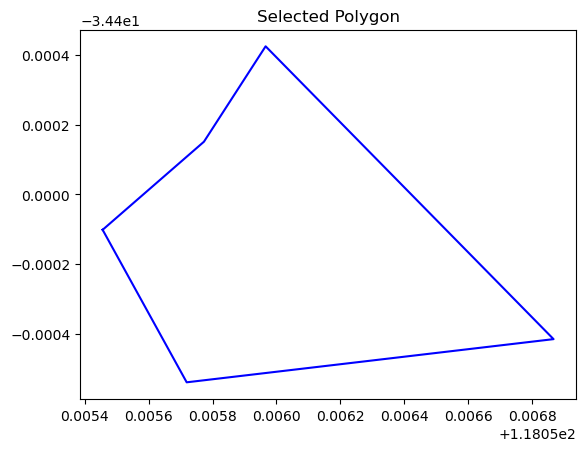

In [110]:
import matplotlib.pyplot as plt
from pyproj import Proj
from shapely.geometry.polygon import LinearRing

# Function to convert latitude and longitude to UTM coordinates
def latlon_to_utm(lat, lon):
    utm_proj = Proj(proj="utm", zone=55, datum="WGS84")  # Change zone as needed - *** WAS 33 as DEFAULT
    utm_x, utm_y = utm_proj(lon, lat)
    return utm_x, utm_y

# Function to display the selected coordinates, UTM coordinates, and visualize the polygon
def display_selected_coordinates(selected_polygon):
    if selected_polygon is not None:
        coords = selected_polygon.exterior.coords
        utm_coords = [latlon_to_utm(lat, lon) for lon, lat in coords]

#        print("The drawn shape was used for selection.")
#        print("The geopolygon of interest is the following one; ")
#        print(selected_polygon)

#        print("\nSelected Polygon Coordinates:")
#        for lon, lat in coords:
#            print(f"Latitude: {lat}, Longitude: {lon}")

#        print("\nUTM Coordinates:")
#        for utm_x, utm_y in utm_coords:
#            print(f"UTM X: {utm_x}, UTM Y: {utm_y}")

        # Visualize the selected polygon
        ring = LinearRing(coords)
        fig, ax = plt.subplots()
        ax.plot(*ring.xy, color="blue")
        ax.set_title("Selected Polygon")
        plt.show()
    else:
        print("No polygon selected")

# Call the function to display the coordinates and visualize the polygon
# Assuming you have the selected polygon stored in a variable named 'selected_polygon'
display_selected_coordinates(selected_polygon)


## Section 4

In [111]:
from datetime import datetime
from IPython.display import display
from ipywidgets import widgets

# Input widgets for specifying the year range
start_date_input = widgets.DatePicker(
    description="Start Date", value=datetime(2010, 1, 1)  # Default value (example)
)

end_date_input = widgets.DatePicker(
    description="End Date", value=datetime(2020, 12, 31)  # Default value (example)
)

# Display date pickers
display(start_date_input, end_date_input)

# Update the global variables with the selected time range
def update_time_range(change):
    global time_range
    start_date = start_date_input.value
    end_date = end_date_input.value
    time_range = (start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))
    print(f"Selected time range: {time_range}")

# Attach the update function to the date pickers
start_date_input.observe(update_time_range, names='value')
end_date_input.observe(update_time_range, names='value')

# Initial call to set the time range
update_time_range(None)


DatePicker(value=datetime.datetime(2010, 1, 1, 0, 0), description='Start Date', step=1)

DatePicker(value=datetime.datetime(2020, 12, 31, 0, 0), description='End Date', step=1)

Selected time range: ('2010-01-01', '2020-12-31')


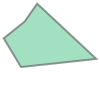

In [112]:
selected_polygon

In [113]:
gdf = gpd.GeoDataFrame({'geometry': [selected_polygon]}, crs="EPSG:4326")

In [114]:
gdf.head()

,geometry
0,"POLYGON ((118.05546 -34.40010, 118.05572 -34.4..."


In [115]:
gdf.explore()

In [116]:
# Dictionary to save results
results = {}

### Loading DEA land cover

#### DEA Land cover

In [117]:
# Section 5: Load Data from Datacube

# Step 1: Check if required variables are defined
if lat_range is None or lon_range is None or start_date_input.value is None or end_date_input.value is None:
    raise ValueError("Latitude, Longitude, or Time range is not defined")

print("Lat Range:", lat_range)
print("Lon Range:", lon_range)
print("Start Date:", start_date_input.value)
print("End Date:", end_date_input.value)

# Step 2: Construct the query
query = {
    "y": lat_range,
    "x": lon_range,
    "time": (start_date_input.value, end_date_input.value),
}

print("Query Parameters:", query)

# Step 3: Load DEA Land Cover data from the datacube
try:
    lc = dc.load(
        product="ga_ls_landcover_class_cyear_2",
        output_crs="EPSG:3577",
        measurements=[
            "level3",
            "lifeform",
            "vegetation_cover",
            "water_seasonality",
            "water_state",
            "intertidal",
            "water_persistence",
            "bare_gradation",
            "full_classification",
        ],
        resolution=(-25, 25),
        **query
    )
    print("Data loaded successfully.")
except Exception as e:
    raise RuntimeError(f"Error loading data from the datacube: {e}")

# Step 4: Check if the dataset is loaded correctly
if lc is None or lc.geobox is None:
    raise ValueError("Failed to load the dataset. Please check the query parameters and ensure data is available for the specified region and time range.")   
    
# Step 5: Print geobox information
geobox = lc.geobox

geobox_info = f"""
Geobox Information:
-------------------
CRS: {geobox.crs}
Dimensions: {geobox.dimensions}
Resolution: {geobox.resolution}
Shape: {geobox.shape}
Extent: {geobox.extent}
"""

print(geobox_info)

# Step 6: Check loaded data dimensions and variables
print("Loaded data dimensions:", lc.dims)
print("Loaded data variables:", lc.data_vars)


Lat Range: (-34.40054, -34.399575)
Lon Range: (118.055456, 118.056867)
Start Date: 2010-01-01 00:00:00
End Date: 2020-12-31 00:00:00
Query Parameters: {'y': (-34.40054, -34.399575), 'x': (118.055456, 118.056867), 'time': (datetime.datetime(2010, 1, 1, 0, 0), datetime.datetime(2020, 12, 31, 0, 0))}


2024-08-15 13:38:49,675 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2024-08-15 13:38:53,952 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2024-08-15 13:38:57,893 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2024-08-15 13:39:02,316 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2024-08-15 13:39:06,093 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


Data loaded successfully.

Geobox Information:
-------------------
CRS: PROJCS["GDA94 / Australian Albers",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",132],PARAMETER["standard_parallel_1",-18],PARAMETER["standard_parallel_2",-36],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3577"]]
Dimensions: ('y', 'x')
Resolution: (-25.0, 25.0)
Shape: (6, 7)
Extent: Geometry({'type': 'Polygon', 'coordinates': (((-1274200.0, -3824850.0), (-1274200.0, -3825000.0), (-1274025.0, -3825000.0), (-1274025.0, -3824850.0), (-1274200.0, -3824850.0)),)}, CRS('

#### Loading the ESA CCI Biomass datasets (2010 and annually from 2015-2021)

In [118]:
# Base path for the files
base_path = "uploads/AGB/S30E110_WA_SWest/"

# Years for which we have data
years = [2010, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

# AGB and SD file paths
AGB_files = {year: f"{base_path}S30E110_{year}_AGBcz.tif" for year in years}
SD_files = {year: f"{base_path}S30E110_{year}_SDcz.tif" for year in years}

# Resample AGB and SD data to geobox and mask invalid data
AGB_prj = {}
SD_prj = {}

for year in years:
    AGB_prj[year] = mask_invalid_data(rio_slurp_xarray(AGB_files[year], lc.geobox, resampling="nearest"))
    SD_prj[year] = mask_invalid_data(rio_slurp_xarray(SD_files[year], lc.geobox, resampling="nearest"))
    AGB_prj[year] = AGB_prj[year].where(AGB_prj[year] != 0)

# Create datasets for AGB and SD
AGB = xr.Dataset({f"AGB{year}": AGB_prj[year] for year in years})
SD = xr.Dataset({f"SD{year}": SD_prj[year] for year in years})

# Calculate biomass differences between years
diff_biomass = xr.Dataset({
    f"d{years[i]}_{years[i+1]}": (AGB[f"AGB{years[i+1]}"].fillna(0) - AGB[f"AGB{years[i]}"].fillna(0)).where((AGB[f"AGB{years[i+1]}"].fillna(0) - AGB[f"AGB{years[i]}"].fillna(0)) != 0)
    for i in range(len(years) - 1)
})

# Calculate minimum and maximum AGB with uncertainty
min_biomass = xr.Dataset({
    f"AGB{year}_Min": AGB[f"AGB{year}"] - SD[f"SD{year}"]
    for year in years
})

max_biomass = xr.Dataset({
    f"AGB{year}_Max": AGB[f"AGB{year}"] + SD[f"SD{year}"]
    for year in years
})

# Calculate conditions for significant decrease and increase in biomass
agb_sc_dec = xr.Dataset({
    f"cond_dec_{years[i]}_{years[i+1]}": (min_biomass[f"AGB{years[i]}_Min"].fillna(0) > max_biomass[f"AGB{years[i+1]}_Max"].fillna(0))
    for i in range(len(years) - 1)
})

agb_sc_inc = xr.Dataset({
    f"cond_inc_{years[i]}_{years[i+1]}": (max_biomass[f"AGB{years[i]}_Max"].fillna(0) < min_biomass[f"AGB{years[i+1]}_Min"].fillna(0))
    for i in range(len(years) - 1)
})

# Combine the decrease and increase datasets
agb_sc = xr.merge([agb_sc_dec, agb_sc_inc])

# At this point, agb_sc contains the conditions for significant decreases and increases in biomass across the years


In [119]:
# Loop through polygons in geodataframe and extract satellite data
for index, row in gdf.iterrows():

    print(f'Feature: {index + 1}/{len(gdf)}')

    # Extract the feature's geometry as a datacube geometry object
    geom = Geometry(geom=row.geometry, crs=gdf.crs)

    # Update the query to include our geopolygon
    query.update({'geopolygon': geom})

    # Mask dataset to set pixels outside the polygon to `NaN`
    AGB_masked = AGB.odc.mask(poly=geom)

    # Add results to dictionary using the attribute column as an key
#    attribute_val = row[attribute_col]
#    results[attribute_val] = AGB_masked

Feature: 1/1


#### Viewing the land cover datasets over the selected time-period
You will be provided with checkboxes that allows you to view the FAO LCCS Level 3 maps and the environmental descriptors (lifeform, canopy cover (%), water state, annual water hydroperiod (or persistence; months) that contribute to the detailed classification of Australia (which can also be viewed).  Other DEA products include the intertidal layer.  

In [120]:
# Section 6: Checkbox widgets for selecting datasets
level3_checkbox = widgets.Checkbox(description='Level 3', value=False)
lifeform_checkbox = widgets.Checkbox(description='Lifeform', value=False)
vegetation_cover_checkbox = widgets.Checkbox(description='Vegetation Cover', value=False)
water_state_checkbox = widgets.Checkbox(description='Water State', value=False)
water_persistence_checkbox = widgets.Checkbox(description='Water Persistence', value=False)
full_classification_checkbox = widgets.Checkbox(description='Full Classification', value=False)
item_checkbox = widgets.Checkbox(description='Intertidal Elevation', value=False)

output = widgets.Output()

def plot_selected_datasets():
    with output:
        output.clear_output()
        selected_datasets = []
        if level3_checkbox.value:
            selected_datasets.append('level3')
        if lifeform_checkbox.value:
            selected_datasets.append('lifeform')
        if vegetation_cover_checkbox.value:
            selected_datasets.append('vegetation_cover')
        if water_state_checkbox.value:
            selected_datasets.append('water_state')
        if water_persistence_checkbox.value:
            selected_datasets.append('water_persistence')            
        if full_classification_checkbox.value:
            selected_datasets.append('full_classification')
        if item_checkbox.value:
            selected_datasets.append('item')

        for dataset in selected_datasets:
            plt.figure()
            if dataset == 'level3':
                plot_land_cover(lc.level3)
            elif dataset == 'lifeform':
                plot_land_cover(lc.lifeform)
            elif dataset == 'vegetation_cover':
                plot_land_cover(lc.vegetation_cover)
            elif dataset == 'water_state':
                plot_land_cover(lc.water_state)
            elif dataset == 'water_persistence':
                plot_land_cover(lc.water_persistence)
            elif dataset == 'full_classification':
                plot_land_cover(lc.full_classification)
            elif dataset == 'item':
                plot_land_cover(item.elevation[0])
            plt.show()

plot_datasets_button = widgets.Button(description='Plot Selected Data')
plot_datasets_button.on_click(lambda b: plot_selected_datasets())

checkboxes_box = widgets.HBox([
    level3_checkbox, 
    lifeform_checkbox, 
    vegetation_cover_checkbox, 
    water_state_checkbox, 
    water_persistence_checkbox, 
    full_classification_checkbox,
    item_checkbox
])
display(checkboxes_box)
display(plot_datasets_button)
display(output)

Button(description='Plot Selected Data', style=ButtonStyle())

Output()

#### Viewing the above ground biomass and change datasets
You can view each dataset for 2010 and annually from 2015-2021 and also the changes between years.

##### **Above ground Biomass of woody vegetation (Mg ha^1)**

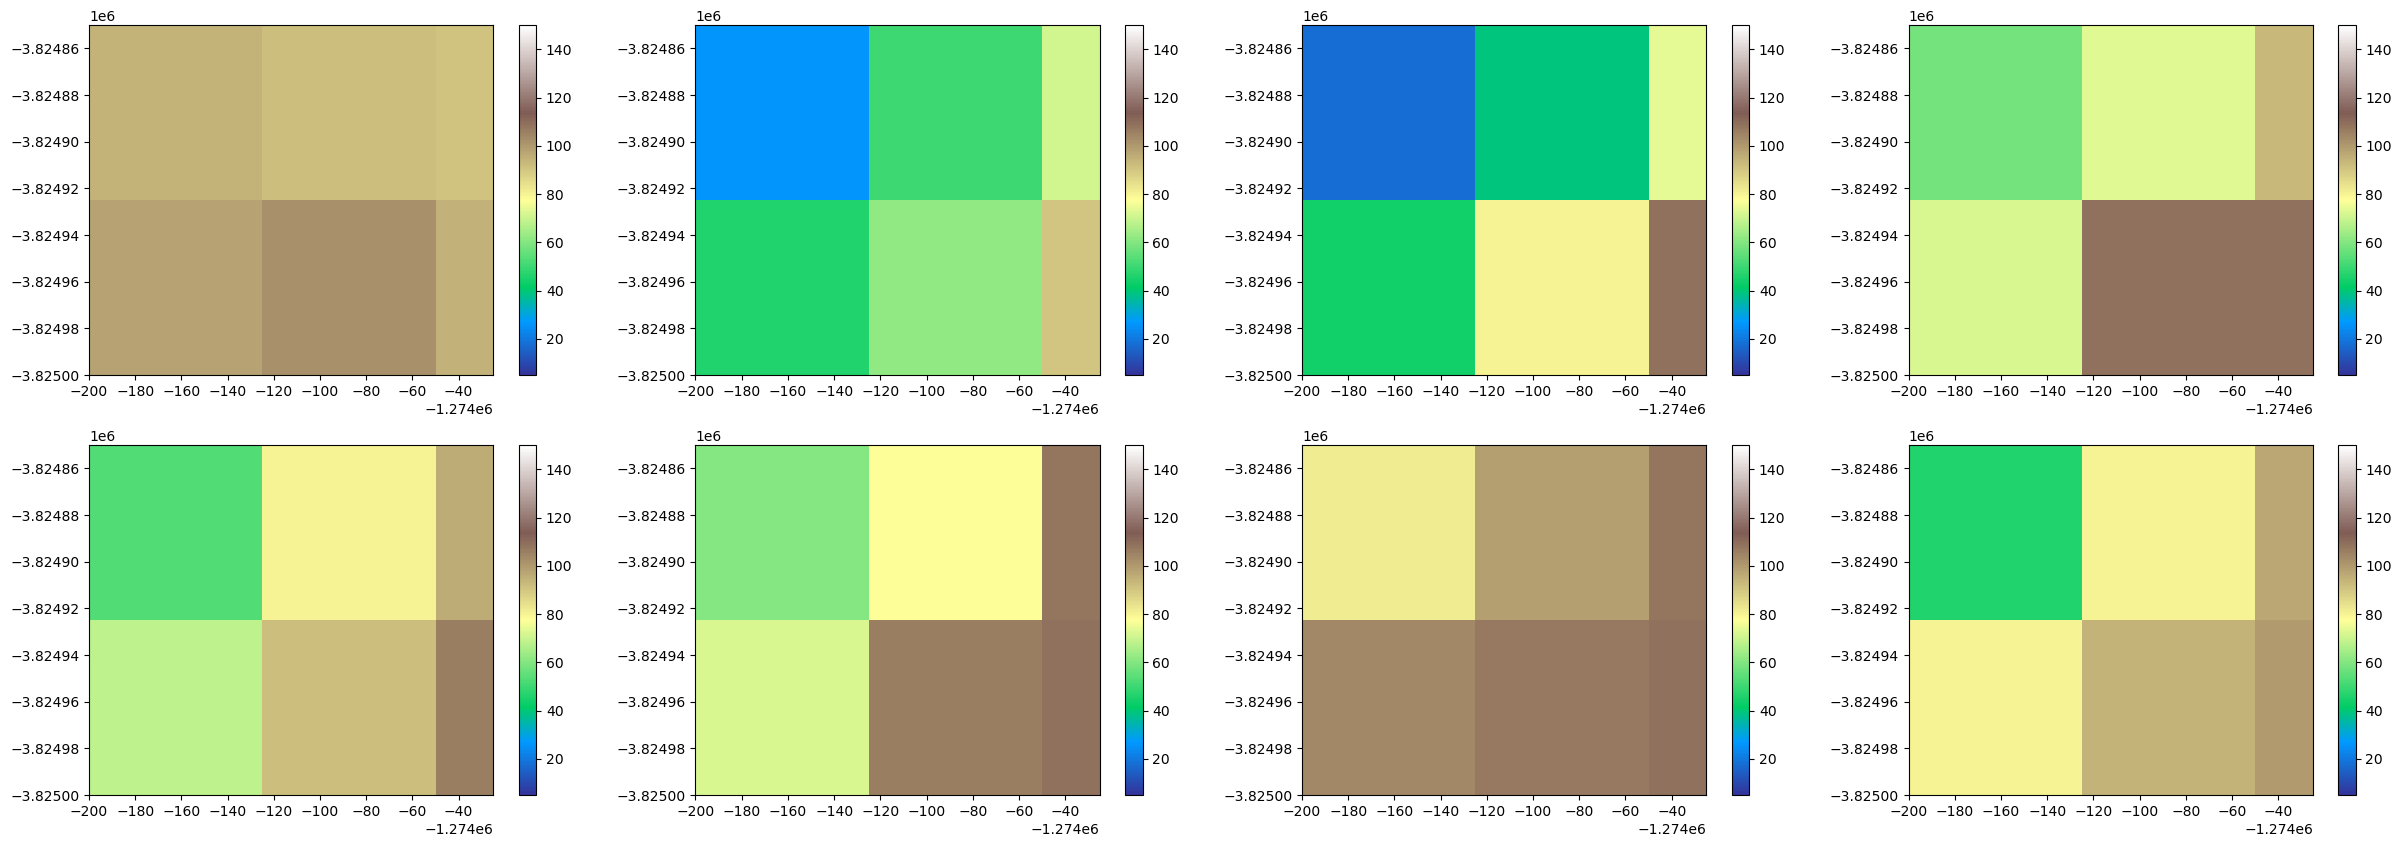

In [121]:
AGB_fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize=(30, 10))
AGB.AGB2010.plot(ax=axs[0,0], cmap='terrain', vmin = 5, vmax = 150, add_labels=False)
AGB.AGB2015.plot(ax=axs[0,1], cmap='terrain', vmin = 5, vmax = 150, add_labels=False)
AGB.AGB2016.plot(ax=axs[0,2], cmap='terrain', vmin = 5, vmax = 150, add_labels=False)
AGB.AGB2017.plot(ax=axs[0,3], cmap='terrain', vmin = 5, vmax = 150, add_labels=False)
AGB.AGB2018.plot(ax=axs[1,0], cmap='terrain', vmin = 5, vmax = 150, add_labels=False)
AGB.AGB2019.plot(ax=axs[1,1], cmap='terrain', vmin = 5, vmax = 150, add_labels=False)
AGB.AGB2020.plot(ax=axs[1,2], cmap='terrain', vmin = 5, vmax = 150, add_labels=False)
AGB.AGB2021.plot(ax=axs[1,3], cmap='terrain', vmin = 5, vmax = 150, add_labels=False)

##### **Changes in the Above ground Biomass of woody vegetation (Mg ha^1)**

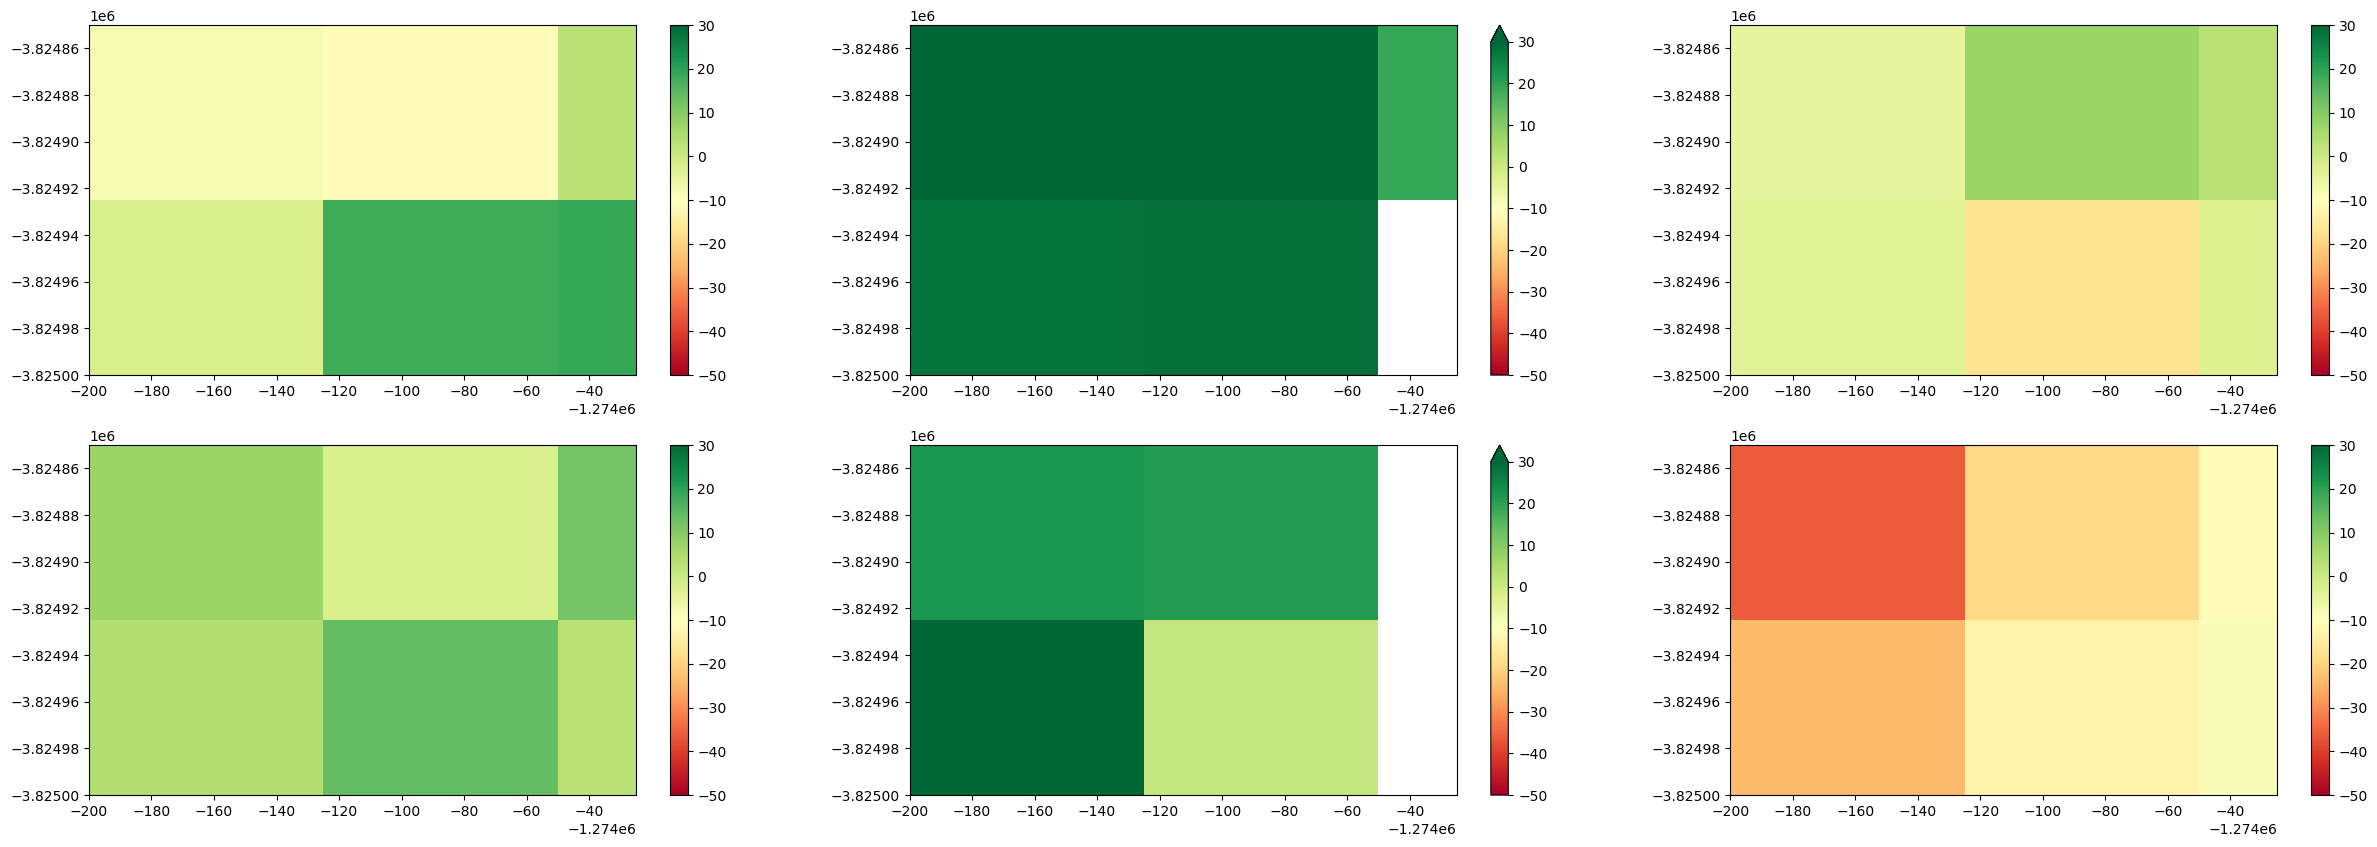

In [122]:
AGB_diff_fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize=(30, 10))
diff_biomass.d2015_2016.plot(ax=axs[0,0], cmap='RdYlGn', vmin = -50, vmax = 30, add_labels=False)
diff_biomass.d2016_2017.plot(ax=axs[0,1], cmap='RdYlGn', vmin = -50, vmax = 30, add_labels=False)
diff_biomass.d2017_2018.plot(ax=axs[0,2], cmap='RdYlGn', vmin = -50, vmax = 30, add_labels=False)
diff_biomass.d2018_2019.plot(ax=axs[1,0], cmap='RdYlGn', vmin = -50, vmax = 30, add_labels=False)
diff_biomass.d2019_2020.plot(ax=axs[1,1], cmap='RdYlGn', vmin = -50, vmax = 30, add_labels=False)
diff_biomass.d2020_2021.plot(ax=axs[1,2], cmap='RdYlGn', vmin = -50, vmax = 30, add_labels=False)

##### **Generating masks of above ground biomass for each year based on the selected polygon area**

In [123]:
# Loop through polygons in geodataframe and extract satellite data
for index, row in gdf.iterrows():

    print(f'Feature: {index + 1}/{len(gdf)}')

    # Extract the feature's geometry as a datacube geometry object
    geom = Geometry(geom=row.geometry, crs=gdf.crs)

    # Update the query to include our geopolygon
    query.update({'geopolygon': geom})

    # Mask dataset to set pixels outside the polygon to `NaN`
    AGB_masked = AGB.odc.mask(poly=geom)

    # Add results to dictionary using the attribute column as an key
#    attribute_val = row[attribute_col]
#    results[attribute_val] = AGB_masked

Feature: 1/1


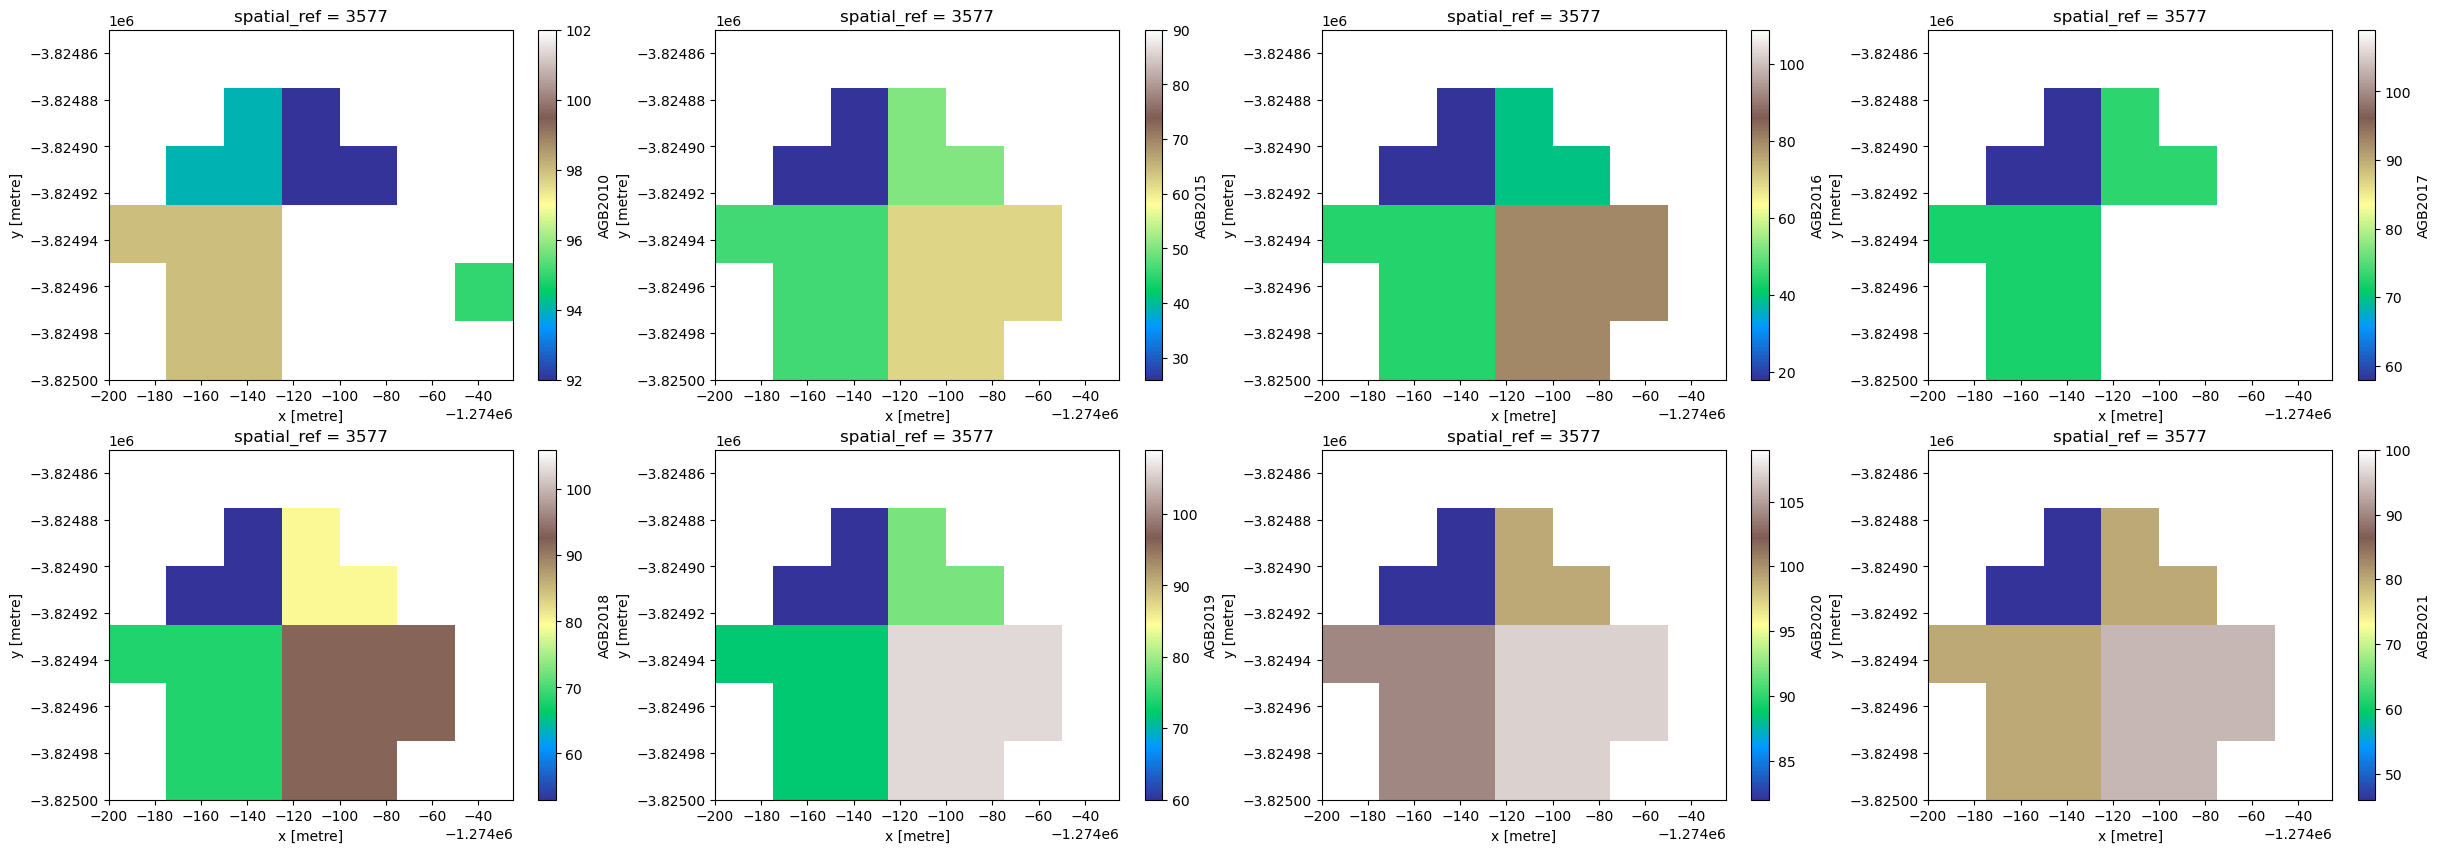

In [124]:
AGB_mk_fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize=(30, 10))
AGB_masked.AGB2010.plot(ax=axs[0,0], cmap='terrain')
AGB_masked.AGB2015.plot(ax=axs[0,1], cmap='terrain')
AGB_masked.AGB2016.plot(ax=axs[0,2], cmap='terrain')
AGB_masked.AGB2017.plot(ax=axs[0,3], cmap='terrain')
AGB_masked.AGB2018.plot(ax=axs[1,0], cmap='terrain')
AGB_masked.AGB2019.plot(ax=axs[1,1], cmap='terrain')
AGB_masked.AGB2020.plot(ax=axs[1,2], cmap='terrain')
AGB_masked.AGB2021.plot(ax=axs[1,3], cmap='terrain')

#### Loading and masking DEA Fractional Cover data from the datacube

In [134]:
fc = dc.load(product='ga_ls_fc_3',
            group_by='solar_day',
            measurements=['bs', 'pv', 'npv', 'ue'],
            like = lc,
            dask_chunks={'x':1024,'y':1024},
)
fc

<xarray.Dataset> Size: 121kB
Dimensions:      (time: 688, y: 6, x: 7)
Coordinates:
  * time         (time) datetime64[ns] 6kB 2010-01-09T01:45:19.407548 ... 201...
  * y            (y) float64 48B -3.825e+06 -3.825e+06 ... -3.825e+06 -3.825e+06
  * x            (x) float64 56B -1.274e+06 -1.274e+06 ... -1.274e+06 -1.274e+06
    spatial_ref  int32 4B 3577
Data variables:
    bs           (time, y, x) uint8 29kB dask.array<chunksize=(1, 6, 7), meta=np.ndarray>
    pv           (time, y, x) uint8 29kB dask.array<chunksize=(1, 6, 7), meta=np.ndarray>
    npv          (time, y, x) uint8 29kB dask.array<chunksize=(1, 6, 7), meta=np.ndarray>
    ue           (time, y, x) uint8 29kB dask.array<chunksize=(1, 6, 7), meta=np.ndarray>
Attributes:
    crs:           PROJCS["GDA94 / Australian Albers",GEOGCS["GDA94",DATUM["G...
    grid_mapping:  spatial_ref

In [126]:
# Loop through polygons in geodataframe and extract satellite data
for index, row in gdf.iterrows():

    print(f'Feature: {index + 1}/{len(gdf)}')

    # Extract the feature's geometry as a datacube geometry object
    geom = Geometry(geom=row.geometry, crs=gdf.crs)

    # Update the query to include our geopolygon
    query.update({'geopolygon': geom})

    # Mask dataset to set pixels outside the polygon to `NaN`
    FC_masked = fc.odc.mask(poly=geom)

    # Add results to dictionary using the attribute column as an key
#    attribute_val = row[attribute_col]
#    results[attribute_val] = AGB_masked

Feature: 1/1


#### Plotting and comparing time-series of above ground biomass and DEA Fractional Cover.

##### *Above ground biomass*

In [127]:
labels = ['2010', '2015', '2016', '2017', '2018', '2019', '2020', '2021']
colors = ['orange', 'orange','orange','orange','orange','orange','orange','orange',]

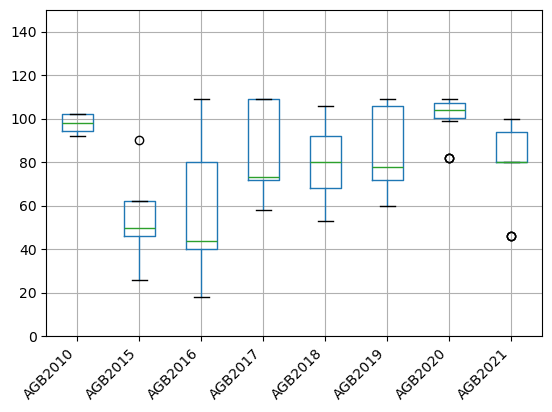

In [131]:
timeseries_AGB = AGB_masked.drop("spatial_ref").to_dataframe()

ax = timeseries_AGB.boxplot()

plt.xticks(rotation=45, ha='right')  
plt.subplots_adjust(bottom=0.2)
ax.set_ylim(0,150)

plt.show()

##### *Fractional cover*
Generating plots of photosynthetic, non-photosynthetic and bare fractions (see DEA https://www.ga.gov.au/scientific-topics/dea/dea-data-and-products/dea-fractional-cover)

2024-08-15 13:39:16,406 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


Text(0.5, 0, 'Years')

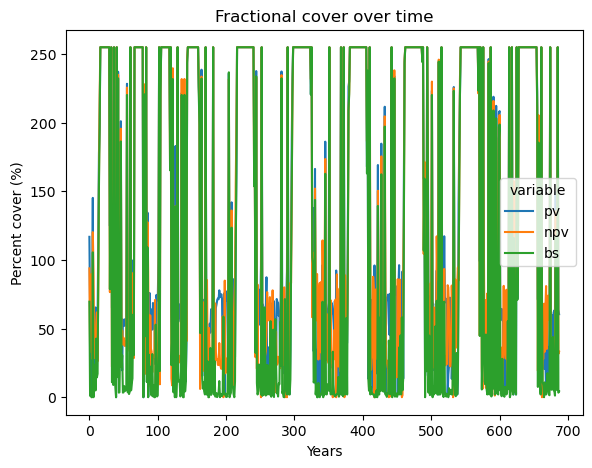

In [130]:
#fc_through_time = FC_masked[['pv', 'npv', 'bs']].resample(time="A").mean(dim=['x', 'y'])
fc_through_time = FC_masked[['pv', 'npv', 'bs']].resample(time="Q").mean(dim=['x', 'y'])

# Plot the changing proportions as a line graph
fc_through_time.to_array().plot.line(hue='variable', size=5)
plt.title('Fractional cover over time')
plt.ylabel('Percent cover (%)');
plt.xlabel('Years')


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)

**Tags**: :index:`sandbox compatible`, :index:`landsat 5`, :index:`landsat 7`, :index:`landsat 8`, 
:index:`DEA Land Cover`, :index:`time series`, :index: `LCCS`, :index:`colour maps`, :index:`data visualisation`